# 365, discharge_spec, 13 stations

In [1]:
from pathlib import Path
import os
import warnings

%load_ext autoreload
%autoreload 2

# ignore warnings for now ...
warnings.filterwarnings('ignore')

if Path('.').absolute().parents[1].name == 'ml_drought':
    os.chdir(Path('.').absolute().parents[1])

!pwd

/home/jovyan/ml_drought


In [2]:
import xarray as xr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle
import torch

from typing import List, Union, Optional, Tuple, Dict

data_dir = Path('data/')
# data_dir = Path('/Volumes/Lees_Extend/data/zip_data')
# data_dir = Path('/Volumes/Lees_Extend/data/ecmwf_sowc/data/')
# plot_dir = Path('/Users/tommylees/Downloads')

assert data_dir.exists()

In [3]:
import seaborn as sns
from src.utils import drop_nans_and_flatten

from src.analysis import read_train_data, read_test_data, read_pred_data
from src.analysis.evaluation import join_true_pred_da
from src.models import load_model

In [4]:
np.array(sorted([d.name for d in (data_dir / "models/").glob("*timestep*")]))

array(['2020_04_07:171723_one_timestep_forecast',
       '2020_04_13:090536_one_timestep_forecast',
       '2020_04_13:091211_one_timestep_forecast',
       '2020_04_13:144437_one_timestep_forecast',
       '2020_04_13:155432_one_timestep_forecast',
       '2020_04_13:171738_one_timestep_forecast',
       '2020_04_15:095841_one_timestep_forecast', 'one_timestep_forecast',
       'one_timestep_forecast_19epoch_static',
       'one_timestep_forecast_1epoch',
       'one_timestep_forecast_1epoch_static',
       'one_timestep_forecast_20epoch',
       'one_timestep_forecast_20epoch_static',
       'one_timestep_forecast_ORIGINAL'], dtype='<U39')

In [5]:
# np.array(sorted([d.name for d in (data_dir / "features/one_timestep_forecast").glob("*")]))

In [6]:
EXPERIMENT =      '2020_04_15:095841_one_timestep_forecast'
TRUE_EXPERIMENT = 'one_timestep_forecast'
TARGET_VAR =      'discharge_spec'
N_EPOCHS = 100

assert (data_dir / f"models/{EXPERIMENT}").exists()
assert (data_dir / f"features/{TRUE_EXPERIMENT}").exists()

# Read in data

In [7]:
# read in model
ealstm = load_model(data_dir / f'models/{EXPERIMENT}/ealstm/model.pt')

Using the Dynamic DataLoader
	Target Var: discharge_spec
	Test Years: [2011 2012 2013 2014 2015 2016]


In [8]:
# read in model predictions
ealstm_pred = read_pred_data('ealstm', data_dir, experiment=EXPERIMENT)
ealstm_pred['station_id'] = ealstm_pred['station_id'].astype(int)

Reading all .nc files from: data/models/2020_04_15:095841_one_timestep_forecast/ealstm
All datasets loaded. Now combining ...


In [9]:
# read in the training data
ds = xr.open_dataset(Path(f'data/features/{TRUE_EXPERIMENT}/data.nc'))

# static_ds = xr.open_dataset(Path(f'data/features/static/data.nc'))
all_static = xr.open_dataset(Path(f'data/interim/static/data.nc'))
all_static['station_id'] = all_static['station_id'].astype(int)
static_ds = all_static.drop(ealstm.static_ignore_vars)

ds['station_id'] = ds['station_id'].astype(int)
ds

<xarray.Dataset>
Dimensions:         (station_id: 13, time: 16436)
Coordinates:
  * station_id      (station_id) int64 12002 15006 27009 ... 54057 71001 84013
  * time            (time) datetime64[ns] 1970-10-01 1970-10-02 ... 2015-09-30
Data variables:
    precipitation   (time, station_id) float64 ...
    temperature     (time, station_id) float64 ...
    discharge_spec  (time, station_id) float64 ...
    peti            (time, station_id) float64 ...
    humidity        (time, station_id) float64 ...
    shortwave_rad   (time, station_id) float64 ...
    longwave_rad    (time, station_id) float64 ...
    windspeed       (time, station_id) float64 ...

In [10]:
# get the observed y_test
times = ealstm_pred.time.values
station_ids = ealstm_pred.station_id.values

In [11]:
print(f"\n** N Stations ignored: {ds.station_id.shape[0] - len(station_ids)} **\n")

ignored_stations = sorted([st for st in ds.station_id.values if st not in station_ids])
names = all_static.sel(station_id=ignored_stations)['gauge_name'].values
print(np.array([f"{i}: {nm}" for i, nm in zip(ignored_stations, names)]), "\n\n")


** N Stations ignored: 0 **

[] 




In [12]:
# Get the predicted and true data
# 'target_var_original' 'discharge_spec'
y_test = ds[TARGET_VAR].sel(station_id=station_ids).sel(time=times)
true_da = y_test

# pred_da = np.exp(ealstm_pred['preds']) - 0.001
pred_da = ealstm_pred['preds']

print(f"{true_da.mean().values}, {true_da.std().values}")
print(f"{pred_da.mean().values}, {pred_da.std().values}")

# check that they are more or less correctly transformed
# assert np.isclose(true_da.mean().values, pred_da.mean().values, atol=0.1)
# assert np.isclose(true_da.std().values, pred_da.std().values, atol=0.4)

print('\n')
display("pred_da coordinates", pred_da.coords)
display("true_da coordinates", true_da.coords)

1.8234590469429406, 2.480724515638711
1.4362033605575562, 1.5984694957733154




'pred_da coordinates'

Coordinates:
  * station_id  (station_id) int64 12002 15006 27009 27034 ... 54057 71001 84013
  * time        (time) datetime64[ns] 2011-01-01 2011-01-02 ... 2015-09-30

'true_da coordinates'

Coordinates:
  * station_id  (station_id) int64 12002 15006 27009 27034 ... 54057 71001 84013
  * time        (time) datetime64[ns] 2011-01-01 2011-01-02 ... 2015-09-30

In [13]:
# join the true and the pred data into one pd.DataFrame
df = (
    join_true_pred_da(
        true_da, pred_da
    ).to_dataframe()
    .reset_index()
    .set_index('time')
)

df.head()

,station_id,discharge_spec,preds
time,,,
2011-01-01,12002,3.28,2.360405
2011-01-02,12002,1.91,2.197551
2011-01-03,12002,1.62,2.019991
2011-01-04,12002,1.58,2.079992
2011-01-05,12002,1.60,2.361119


In [14]:
# print the model training features
LOGY = False
ljust = 30

print(
    "", "MODEL NAME: ".ljust(ljust), f"{EXPERIMENT}\n",
    "Target Var: ".ljust(ljust), f"{ealstm.target_var}\n",
    "Log y: ".ljust(ljust), f"{LOGY}\n",
    "Normalize y: ".ljust(ljust), f"{ealstm.normalize_y}\n",
    "Train Years: ".ljust(ljust), f"{ds['time.year'].min().values}: {min(ealstm.test_years) -1}\n",
    "Test Years: ".ljust(ljust), f"{[y for y in ealstm.test_years if y in ds['time.year'].values]}\n",
    "N Stations: ".ljust(ljust), f"{len(df.station_id.unique())}\n",
    "Dynamic Variables: ".ljust(ljust), f"{[v for v in list(ds.data_vars) if v not in list(set(ealstm.dynamic_ignore_vars))]}\n",
    "Static Variables: ".ljust(ljust), f"{list(static_ds.data_vars)}\n", 
    "Sequence Length: ".ljust(ljust), f"{ealstm.seq_length}\n", 
    "Final Linear Layer size: ".ljust(ljust), f"{ealstm.dense_features}\n", 
    "Static Embedding Size: ".ljust(ljust), f"{ealstm.static_embedding_size}\n", 
    "Num Epochs: ".ljust(ljust), f"{N_EPOCHS}\n", 
#     "VAR: ".ljust(ljust), f"{VAR}\n", 
)

 MODEL NAME:                    2020_04_15:095841_one_timestep_forecast
 Target Var:                    discharge_spec
 Log y:                         False
 Normalize y:                   True
 Train Years:                   1970: 2010
 Test Years:                    [2011, 2012, 2013, 2014, 2015]
 N Stations:                    13
 Dynamic Variables:             ['precipitation', 'temperature', 'peti', 'humidity', 'shortwave_rad', 'longwave_rad', 'windspeed']
 Static Variables:              ['area', 'dpsbar', 'elev_mean', 'sand_perc', 'silt_perc', 'clay_perc', 'porosity_hypres', 'conductivity_hypres', 'soil_depth_pelletier', 'slope_fdc', 'baseflow_index', 'p_mean', 'pet_mean', 'aridity', 'p_seasonality', 'frac_snow', 'high_prec_freq', 'high_prec_dur', 'low_prec_freq', 'low_prec_dur', 'dwood_perc', 'ewood_perc', 'crop_perc', 'urban_perc', 'reservoir_cap']
 Sequence Length:               365
 Final Linear Layer size:       [256, 1]
 Static Embedding Size:         256
 Num Epochs:      

# run performance metrics


In [15]:
from src.analysis.evaluation import (r2_score, rmse, spatial_rmse, spatial_r2, spatial_nse)
from src.analysis.evaluation import temporal_rmse, temporal_r2, temporal_nse

In [16]:
# calculate performance for each station (collapse time)
rmse_da = spatial_rmse(y_test, pred_da)
r2_da = spatial_r2(y_test, pred_da)
nse_da = spatial_nse(y_test, pred_da)

# calculate performance for each station (collapse space)
rmse_time = temporal_rmse(y_test, pred_da)
r2_time = temporal_r2(y_test, pred_da)
nse_time = temporal_nse(y_test, pred_da)

In [17]:
print(f"Mean Station RMSE: {rmse_da.mean().values:.2f}")
print(f"Mean Station NSE: {(nse_da.where(nse_da > -np.inf)).mean().values:.2f}")
print(f"Mean Station R2: {r2_da.mean().values:.2f}")

print(f"\n\nMean Time RMSE: {rmse_time.mean().values:.2f}")
print(f"Mean Time NSE: {nse_time.mean().values:.2f}")
print(f"Mean Time R2: {r2_time.mean().values:.2f}")

Mean Station RMSE: 1.13
Mean Station NSE: 0.70
Mean Station R2: 0.76


Mean Time RMSE: 0.84
Mean Time NSE: 0.54
Mean Time R2: 0.64


In [18]:
# rmse and r2 df
metrics_df = rmse_da.to_dataframe().drop(columns='time').rename(columns={"preds": "rmse"}).join(
    r2_da.to_dataframe().drop(columns='time').rename(columns={"preds": "r2"})
)
metrics_df = metrics_df.join(
    nse_da.to_dataframe().rename(columns={"preds": "nse"})
)

metrics_df = metrics_df.reset_index()
metrics_df.head()

,station_id,rmse,r2,nse
0,12002,1.670608,0.557724,0.485321
1,15006,1.779558,0.782911,0.640151
2,27009,0.738994,0.789585,0.789520
3,27034,2.798811,0.612048,0.550224
4,27041,0.353376,0.866646,0.807263


In [19]:
# TEMPORAL rmse and r2 df
metrics_time = rmse_time.to_dataframe().rename(columns={TARGET_VAR: "rmse"}).join(
    r2_time.to_dataframe().rename(columns={TARGET_VAR: "r2"})
)
metrics_time = metrics_time.join(
    nse_time.to_dataframe().rename(columns={TARGET_VAR: "nse"})
)

metrics_time = metrics_time.reset_index()
metrics_time['time'] = [pd.to_datetime(t) for t in metrics_time.time]
metrics_time.head()

,time,rmse,r2,nse
0,2011-01-01,0.543590,0.640549,0.561373
1,2011-01-02,0.402848,0.436366,0.407700
2,2011-01-03,0.357898,0.342745,0.334587
3,2011-01-04,0.411285,0.482561,0.477989
4,2011-01-05,0.529003,0.833809,0.833466


## Performance Plots

In [20]:
nse_df = nse_da.sortby(nse_da).to_dataframe().reset_index().dropna()

# replace the negative infinity value
# nse_df['error'] = (nse_df.preds == -np.inf)
# nse_df.loc[nse_df.preds == -np.inf, "preds"] = -125

# ignore the negative infinity value
# nse_df = nse_df.loc[nse_df.preds != -np.inf]

# get cumsum of index
nse_df['index'] = nse_df.index

nse_df['negative'] = nse_df.preds < 0

nse_df.head()

,station_id,preds,index,negative
0,12002,0.485321,0,False
1,27034,0.550224,1,False
2,71001,0.585759,2,False
3,15006,0.640151,3,False
4,39081,0.647464,4,False


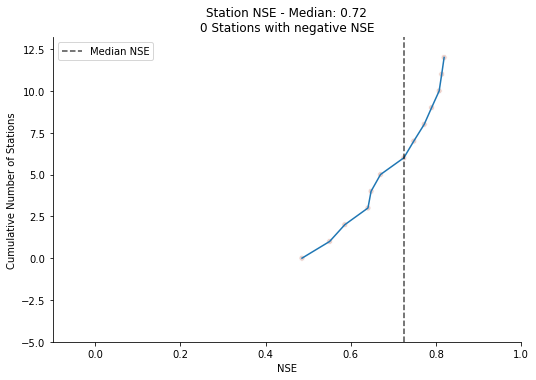

In [49]:
data = nse_df.loc[nse_df['preds'] >= -0.1]
median_nse = nse_df.loc[nse_df.preds != -np.inf, 'preds'].median()

scale = 0.7
fig, ax = plt.subplots(figsize=(12*scale, 8*scale))

# plot the points
sns.lineplot(x='preds', y='index', ax=ax, data=data)
sns.scatterplot(x='preds', y='index', hue='negative', x_jitter=2, ax=ax, data=data, alpha=1, legend=False)

ymax=nse_df['index'].max()
ax.axvline(median_nse, ymin=0, ymax=ymax, color='k', ls='--', label='Median NSE', alpha=0.7)

# beautify the plot
ax.set_ylim(-5, ymax*1.1)
ax.set_xlim(-0.1, 1)

ax.legend()

ax.set_title(f'Station NSE - Median: {median_nse:.2f}\n{nse_df.negative.sum()} Stations with negative NSE')
ax.set_xlabel('NSE')
ax.set_ylabel('Cumulative Number of Stations');

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False);

# Join to make geographical

In [22]:
import geopandas as gpd

shp_path = Path(
    "/home/jovyan/runoff_uk_lstm/data/CAMELS/CAMELS_GB_DATASET/Catchment_Boundaries/CAMELS_GB_catchment_boundaries.shp"
)
shp_path.exists()

True

In [23]:
# load in the shapefile
geo_df = gpd.read_file(shp_path)
geo_df['ID_STRING'] = geo_df['ID_STRING'].astype('int')
geo_df.head()

,ID_STRING,ID,SOURCE,VERSION,EXPORTED,geometry
0,10002,10002.0,National River Flow Archive,1.3,2018-02-12,"POLYGON ((410125.0000999998 848525.0000999998,..."
1,10003,10003.0,National River Flow Archive,1.3,2018-02-12,"POLYGON ((394725.0000999998 830350.0000999998,..."
2,1001,1001.0,National River Flow Archive,1.3,2018-02-12,"POLYGON ((326225.0000999998 954900.0000999998,..."
3,101002,101002.0,National River Flow Archive,1.3,2018-02-12,"POLYGON ((450375.0000999998 88125.00009999983,..."
4,101005,101005.0,National River Flow Archive,1.3,2018-02-12,"POLYGON ((453125.0000999998 83525.00009999983,..."


In [24]:
# create spatial dataframe
assert metrics_df['station_id'].dtype == geo_df['ID_STRING'].dtype, "Need to be the same type (integer)"
metrics_gdf = gpd.GeoDataFrame(
    geo_df.set_index('ID_STRING').join(metrics_df.set_index('station_id'))
)
metrics_gdf.head()

,ID,SOURCE,VERSION,EXPORTED,geometry,rmse,r2,nse
ID_STRING,,,,,,,,
10002,10002.0,National River Flow Archive,1.3,2018-02-12,"POLYGON ((410125.0000999998 848525.0000999998,...",NaN,NaN,NaN
10003,10003.0,National River Flow Archive,1.3,2018-02-12,"POLYGON ((394725.0000999998 830350.0000999998,...",NaN,NaN,NaN
1001,1001.0,National River Flow Archive,1.3,2018-02-12,"POLYGON ((326225.0000999998 954900.0000999998,...",NaN,NaN,NaN
101002,101002.0,National River Flow Archive,1.3,2018-02-12,"POLYGON ((450375.0000999998 88125.00009999983,...",NaN,NaN,NaN
101005,101005.0,National River Flow Archive,1.3,2018-02-12,"POLYGON ((453125.0000999998 83525.00009999983,...",NaN,NaN,NaN


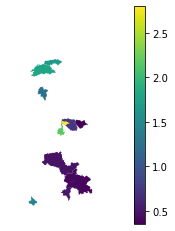

In [25]:
ax = metrics_gdf.plot('rmse', legend=True)
ax.axis('off');

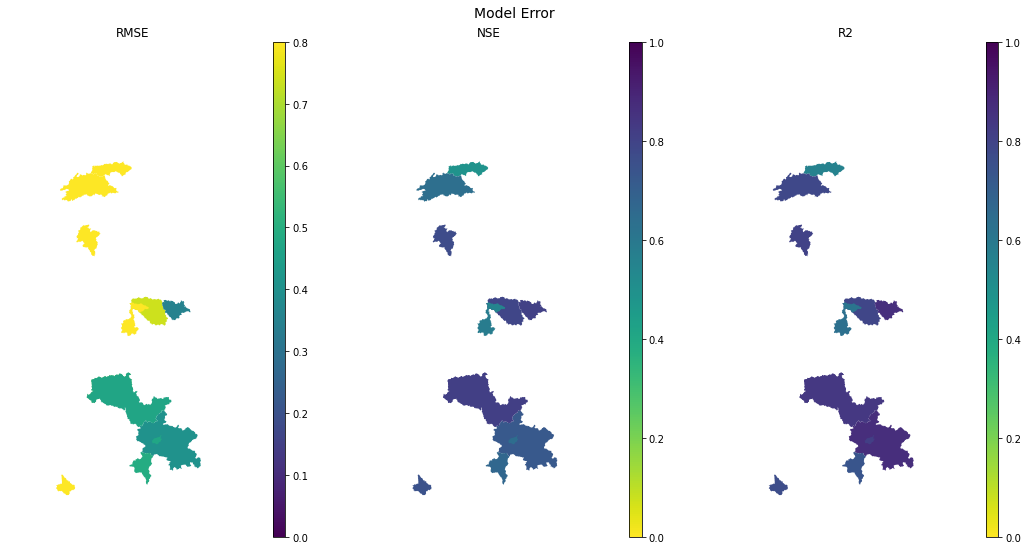

In [26]:
from mpl_toolkits.axes_grid1 import make_axes_locatable
fig, axs = plt.subplots(1, 3, figsize=(15, 8))
opts = [
    {"vmin": 0, "vmax": 0.8, 'cmap': 'viridis'},   # rmse   
    {"vmin": 0, "vmax": 1, 'cmap': 'viridis_r'},    # nse   
    {"vmin": 0, "vmax": 1, 'cmap': 'viridis_r'}    # r2  
]

for ix, metric in enumerate(["rmse", "nse", "r2"]):
    ax = axs[ix]
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.2) # depends on the user needs

    # legend_kwargs = {'label': metric.upper(), 'orientation': 'horizontal'}
    metrics_gdf.plot(
        column=metric, ax=ax, 
        cmap=opts[ix]['cmap'],legend=True, cax=cax,
        vmin=opts[ix]['vmin'], vmax=opts[ix]['vmax'],
    )  #, legend_kwds=legend_kwargs)

    ax.set_title(f'{metric.upper()}')

    ax.axis('off');

fig.tight_layout(rect=[0, 0.03, 1, 0.965])
fig.suptitle("Model Error", size=14);

# Crooks and Martinez stations

In [27]:
catchment_ids = ["12002", "15006", "27009", "27034", "27041", "39001",
                 "39081", "43021", "47001", "54001", "54057", "71001", "84013", ]
catchment_ids = [int(c_id) for c_id in catchment_ids]
catchment_names = ["Dee@Park", "Tay@Ballathie", "Ouse@Skelton", "Ure@Kilgram", "Derwent@Buttercrambe", "Thames@Kingston",
                   "Ock@Abingdon", "Avon@Knapp", "Tamar@Gunnislake", "Severn@Bewdley", "Severn@Haw", "Ribble@Samlesbury", "Clyde@Daldowie"]
station_map = dict(zip(catchment_ids, catchment_names))

In [28]:
valid_catchment_ids = [c for (ix, c) in enumerate(catchment_ids) if c in ealstm_pred.station_id.values]
valid_station_name = np.array(catchment_names)[[ix for (ix, c) in enumerate(catchment_ids) if c in ealstm_pred.station_id.values]]
# for ix, (station_id, station_name) in enumerate(zip(valid_catchment_ids, valid_station_name)):
#     print(f"{station_name} ID: {station_id}")
#     print(f"\tRMSE: {rmse_da.sel(station_id=station_id).values:.2f}")
#     print(f"\tNSE: {nse_da.sel(station_id=station_id).values:.2f}")
#     print(f"\tR2: {r2_da.sel(station_id=station_id).values:.2f}")
#     print("\n")

In [29]:
metadata = gpd.GeoDataFrame(
    geo_df.set_index('ID_STRING')
    .join(all_static[['gauge_name', 'gauge_lat', 'gauge_lon']]
    .to_dataframe())
)
metrics_gdf = metadata.join(metrics_df.set_index('station_id'))

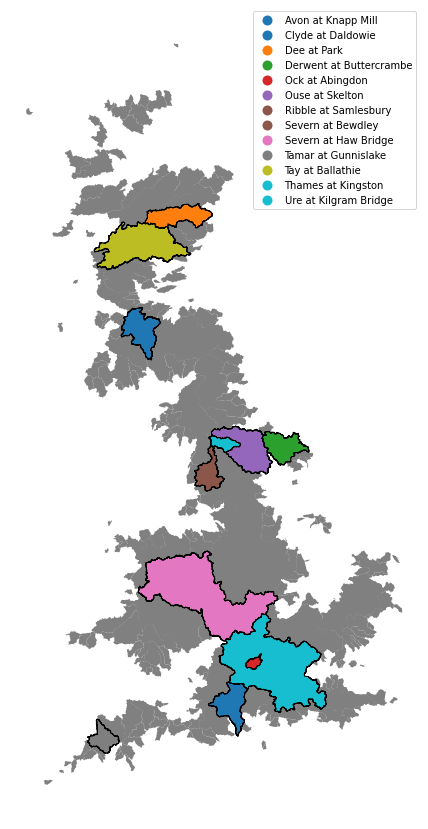

In [30]:
fig, ax = plt.subplots(figsize=(12, 15))

geo_df.plot(ax=ax, color='grey')
metadata.loc[np.isin(metadata.index, valid_catchment_ids)].plot(
    'gauge_name', ax=ax, edgecolor='k', color=None, legend=True,
)

ax.axis('off');

In [31]:
def plot_station_scatter(
    df: pd.DataFrame, station_id: str, metrics_df: Optional[pd.DataFrame] = None, ax=None,
    target_var: str = 'discharge_spec',
    station_name: Optional[str] = None
):
    # select station
    d = df.query(f"station_id == '{station_id}'").drop(columns='station_id')
    
    if ax is None:
        fig, ax = plt.subplots(figsize=(12, 6))
    else:
        fig = plt.gcf()
    
    # plot scatter
    ax.plot(d[target_var], d.preds, 'kx', alpha=0.6, label='Data Point')
    # plot 1:1 line
    line_1_1_x = np.linspace(d[target_var].min(), d[target_var].max(), 10)
    ax.plot(line_1_1_x, line_1_1_x, 'k--', label='1:1 Line')

    ax.set_xlabel('Observed')
    ax.set_ylabel('Predicted')
    title = f'Station {station_id}' + f" {station_name}" if station_name is not None else f'Station {station_id}'
    ax.set_title(title)

    ax.legend();
    
    if False:
        # making the plot pretty
        for item in ([ax.title, ax.xaxis.label, ax.yaxis.label]
                          + ax.get_xticklabels() + ax.get_yticklabels()):
                item.set_fontsize(12)

    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    
    return fig, ax


def plot_station(
    df: pd.DataFrame, 
    station_id: str, 
    metrics_df: Optional[pd.DataFrame] = None, 
    ax=None,
    station_name: Optional[str] = None,
    plot_years: Optional[List[int]] = None,
):
    """Plot the Observed vs. Preds for the station_id"""
    if ax is None:
        fig, ax = plt.subplots()
    else:
        fig = plt.gcf()
    
    # plot the station
    if plot_years is None:
        df.query(f"station_id == '{station_id}'").drop(columns='station_id').plot(ax=ax)
    else:
        (
            df.loc[np.isin(df.index.year, plot_years)]
            .query(f"station_id == '{station_id}'")
            .drop(columns='station_id').plot(ax=ax)
        )
    
    # get the error metrics
    rmse_val = metrics_df.query(f"station_id == '{station_id}'").rmse.values[0]
    r2_val = metrics_df.query(f"station_id == '{station_id}'").r2.values[0]
    nse_val = metrics_df.query(f"station_id == '{station_id}'").nse.values[0]
    # set the title
    station_title = f"{station_id} {station_name}" if station_name is not None else station_id
    ax.set_title(f"{station_title}\nRMSE: {rmse_val:.2f} R2: {r2_val:.2f} NSE: {nse_val:.2f}")
    
    return fig, ax

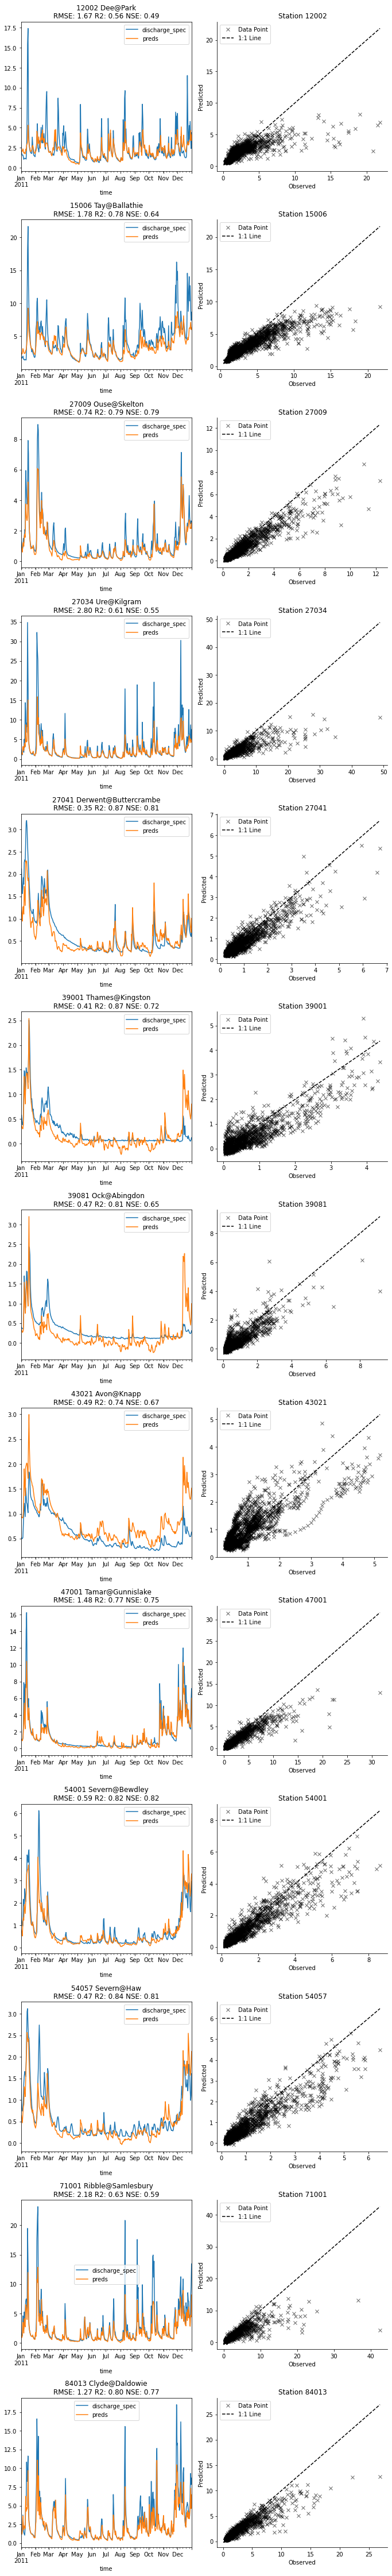

In [32]:
# test_stations = ['22007', '27049', '28018', '31021', '31023', '34004', '35003', '39022', '41029', '51001', '55025', '57004', '83010']
catchment_ids = ["12002", "15006", "27009", "27034", "27041", "39001", "39081", "43021", "47001", "54001", "54057", "71001", "84013",]
catchment_names = ["Dee@Park", "Tay@Ballathie", "Ouse@Skelton", "Ure@Kilgram", "Derwent@Buttercrambe", "Thames@Kingston", "Ock@Abingdon", "Avon@Knapp", "Tamar@Gunnislake", "Severn@Bewdley", "Severn@Haw", "Ribble@Samlesbury", "Clyde@Daldowie"]
station_map = dict(zip(catchment_ids, catchment_names))

plot_years = [2011]
scale = 0.8
fig, axs = plt.subplots(13, 2, figsize=(12*scale, 6*scale*13))

for ix, (station_id, station_name) in enumerate(zip(catchment_ids, catchment_names)):
#     fig, axs = plt.subplots(1, 2, figsize=(12*scale, 6*scale))
    try:
        plot_station(df, station_id, metrics_df, ax=axs[ix, 0], station_name=station_name, plot_years=plot_years)
        plot_station_scatter(df, station_id, metrics_df, axs[ix, 1])
    except TypeError:
        print(f"** {station_name} data does not exist in the predictions! **")
        
    plt.tight_layout()

In [33]:
for ix, (station_id, station_name) in enumerate(zip(catchment_ids, catchment_names)):
    rmse_val = metrics_df.query(f"station_id == '{station_id}'").rmse.values[0]
    r2_val = metrics_df.query(f"station_id == '{station_id}'").r2.values[0]
    nse_val = metrics_df.query(f"station_id == '{station_id}'").nse.values[0]
    # set the title
    station_title = f"{station_id} {station_name}" if station_name is not None else station_id
    print(
        f"{station_title}".ljust(30), 
        f"-- RMSE: {rmse_val:.2f} -- R2: {r2_val:.2f} -- NSE: {nse_val:.2f}"
    )

12002 Dee@Park                 -- RMSE: 1.67 -- R2: 0.56 -- NSE: 0.49
15006 Tay@Ballathie            -- RMSE: 1.78 -- R2: 0.78 -- NSE: 0.64
27009 Ouse@Skelton             -- RMSE: 0.74 -- R2: 0.79 -- NSE: 0.79
27034 Ure@Kilgram              -- RMSE: 2.80 -- R2: 0.61 -- NSE: 0.55
27041 Derwent@Buttercrambe     -- RMSE: 0.35 -- R2: 0.87 -- NSE: 0.81
39001 Thames@Kingston          -- RMSE: 0.41 -- R2: 0.87 -- NSE: 0.72
39081 Ock@Abingdon             -- RMSE: 0.47 -- R2: 0.81 -- NSE: 0.65
43021 Avon@Knapp               -- RMSE: 0.49 -- R2: 0.74 -- NSE: 0.67
47001 Tamar@Gunnislake         -- RMSE: 1.48 -- R2: 0.77 -- NSE: 0.75
54001 Severn@Bewdley           -- RMSE: 0.59 -- R2: 0.82 -- NSE: 0.82
54057 Severn@Haw               -- RMSE: 0.47 -- R2: 0.84 -- NSE: 0.81
71001 Ribble@Samlesbury        -- RMSE: 2.18 -- R2: 0.63 -- NSE: 0.59
84013 Clyde@Daldowie           -- RMSE: 1.27 -- R2: 0.80 -- NSE: 0.77


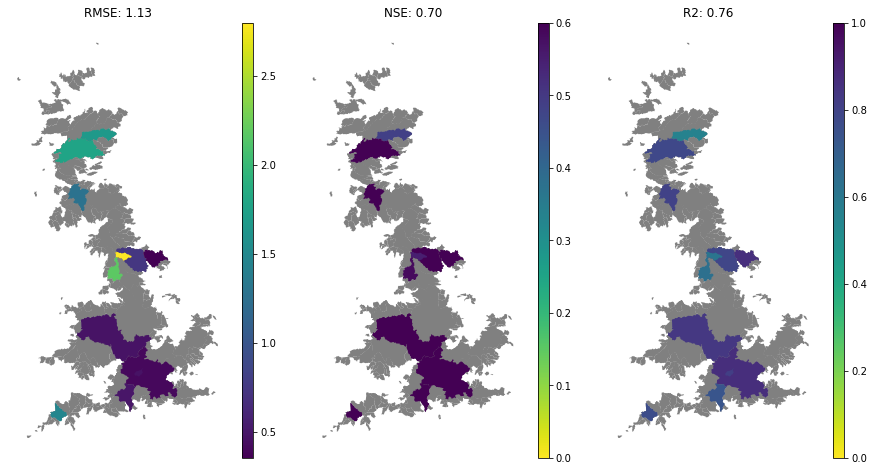

In [34]:
crooks_gdf = metrics_gdf.loc[np.isin(metrics_gdf.index, [int(c) for c in catchment_ids])]
fig, axs = plt.subplots(1, 3, figsize=(15, 15))

for ax in axs:
    metrics_gdf.plot(ax=ax, color='grey')
    ax.axis('off')

divider = make_axes_locatable(axs[0])
cax = divider.append_axes("right", size="5%", pad=0.2) # depends on the user needs
crooks_gdf.plot('rmse', ax=axs[0], legend=True, cax=cax, cmap='viridis')
axs[0].set_title(f"RMSE: {crooks_gdf['rmse'].mean():.2f}")

divider = make_axes_locatable(axs[1])
cax = divider.append_axes("right", size="5%", pad=0.2) # depends on the user needs
crooks_gdf.plot('nse', legend=True, ax=axs[1], cax=cax, cmap='viridis_r', vmin=0, vmax=0.6)
axs[1].set_title(f"NSE: {crooks_gdf['nse'].mean():.2f}")

divider = make_axes_locatable(axs[2])
cax = divider.append_axes("right", size="5%", pad=0.2) # depends on the user needs
crooks_gdf.plot('r2', legend=True, ax=axs[2], cax=cax, cmap='viridis_r', vmin=0, vmax=1)
axs[2].set_title(f"R2: {crooks_gdf['r2'].mean():.2f}");

# Get vars on keyword

In [35]:
from src.preprocess._camels_static_metadata import (get_var_on_dtype, get_vars_on_keywords, get_vars_on_grouping)

In [36]:
static_ds.data_vars

Data variables:
    area                  (station_id) float64 ...
    dpsbar                (station_id) float64 ...
    elev_mean             (station_id) float64 ...
    sand_perc             (station_id) float64 ...
    silt_perc             (station_id) float64 ...
    clay_perc             (station_id) float64 ...
    porosity_hypres       (station_id) float64 ...
    conductivity_hypres   (station_id) float64 ...
    soil_depth_pelletier  (station_id) float64 ...
    slope_fdc             (station_id) float64 ...
    baseflow_index        (station_id) float64 ...
    p_mean                (station_id) float64 ...
    pet_mean              (station_id) float64 ...
    aridity               (station_id) float64 ...
    p_seasonality         (station_id) float64 ...
    frac_snow             (station_id) float64 ...
    high_prec_freq        (station_id) float64 ...
    high_prec_dur         (station_id) float64 ...
    low_prec_freq         (station_id) float64 ...
    low_prec_du

In [37]:
get_vars_on_keywords(all_static, 'lat')

{'gauge_lat': ('n_unique: 426',
  'dtype: float64',
  '#nulls: 0',
  array([50.16, 50.26, 50.27, 50.31, 50.39]))}

In [38]:
dl = ealstm.get_dataloader('train')
type(dl)


src.models.dynamic_data.DynamicDataLoader

In [39]:
data = dl.__iter__().__next__()

In [40]:
data[0][0].shape

(13, 365, 7)

In [41]:
len_mask = len(dl.valid_train_times)
len_mask

14702

In [42]:
from src.models.data import train_val_mask
train_mask, val_mask = train_val_mask(len_mask, 0.1)


# Measure model bias

In [43]:
bias = 100 * ((pred_da / true_da) - 1)
bias.mean()

<xarray.DataArray ()>
array(-16.51379517)

In [44]:
print(bias.mean(dim='time').mean())
print(bias.mean(dim='station_id').mean())

<xarray.DataArray ()>
array(-16.50719423)
<xarray.DataArray ()>
array(-16.51397826)


In [45]:
nse_da.where(nse_da > -np.inf).mean()

<xarray.DataArray 'preds' ()>
array(0.69627459)

In [46]:
nse_df = nse_da.sortby(nse_da).to_dataframe().reset_index().dropna()

# replace the negative infinity value
# nse_df['error'] = (nse_df.preds == -np.inf)
# nse_df.loc[nse_df.preds == -np.inf, "preds"] = -125

# ignore the negative infinity value
# nse_df = nse_df.loc[nse_df.preds != -np.inf]

# get cumsum of index
nse_df['index'] = nse_df.index

nse_df['negative'] = nse_df.preds < 0

nse_df.head()

,station_id,preds,index,negative
0,12002,0.485321,0,False
1,27034,0.550224,1,False
2,71001,0.585759,2,False
3,15006,0.640151,3,False
4,39081,0.647464,4,False


In [47]:
sns.scatterplot

<function seaborn.relational.scatterplot(x=None, y=None, hue=None, style=None, size=None, data=None, palette=None, hue_order=None, hue_norm=None, sizes=None, size_order=None, size_norm=None, markers=True, style_order=None, x_bins=None, y_bins=None, units=None, estimator=None, ci=95, n_boot=1000, alpha='auto', x_jitter=None, y_jitter=None, legend='brief', ax=None, **kwargs)>

In [48]:
pd.Series([i+1 for i in nse_df.index]).rolling(window=1).sum()

0      1.0
1      2.0
2      3.0
3      4.0
4      5.0
5      6.0
6      7.0
7      8.0
8      9.0
9     10.0
10    11.0
11    12.0
12    13.0
dtype: float64